In [166]:
import alpaca_trade_api as tradeapi
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest, StockLatestQuoteRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import config
import csv
from datetime import datetime, timedelta, timezone
import json
import logging
import math
import mplfinance as mpf
import matplotlib.pyplot as plt
import os
import pandas as pd
import polars as pl
import plotly.graph_objects as go
import seaborn as sns
import time


In [167]:
POSITION_FILE: str = 'position.json' 
SYMBOL: str = 'SPY'
MAX_TRADES_PER_DAY: int = 10        # Maximum trades allowed per day
DAILY_LOSS_LIMIT: int  = 100       # Maximum daily loss allowed (in dollars)
POSITION_SIZE_PCT: float = 0.1        # 10% of buying power per trade
COOLDOWN: int = 60 * 5              # 5 minutes cooldown in seconds
TRAILING_STOP_PCT: float = 0.02       # 2% trailing stop

# Initial position dictionary
initial_position_data = {
    "side": "long",
    "entry_price": 180.50,
    "qty": 10,
    "high": 180.50,
    "low": 180.00,
    "entry_time": datetime.now().isoformat(),
    "last_exit": ""
} 

# Remove existing handlers (important in Jupyter)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Now set up logging to file
logging.basicConfig(
    filename='app.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='a'
)

# Test it
logging.info("Logging from Jupyter is working.")

In [168]:
def create_position_file_if_not_exists() -> None:
    """Creates the position.json file with initial data if it doesn't exist."""
    if not os.path.exists(POSITION_FILE):
        try:
            with open(POSITION_FILE, 'w') as f:
                json.dump(initial_position_data, f, indent=4)
            logging.info(f"'{POSITION_FILE}' not found. Created and initialized it.")
        except Exception as e:
            logging.error(f"Error creating '{POSITION_FILE}': {e}", exc_info=True)
    else:
        logging.info(f"'{POSITION_FILE}' already exists.")


In [169]:
create_position_file_if_not_exists()

In [170]:
def load_position() -> list[dict] | None:
    """Loads the trading position from the position.json file, ensuring recovery from corruption or absence."""
    create_position_file_if_not_exists()

    try:
        with open(POSITION_FILE, 'r') as f:
            position_data: list[dict] = json.load(f)
            logging.info(f"Successfully loaded position from {POSITION_FILE}")
            return position_data

    except json.JSONDecodeError:
        logging.warning(f"Error decoding JSON from {POSITION_FILE}. File might be corrupted. Attempting to fix.")
        try:
            os.remove(POSITION_FILE)
            logging.info(f"Deleted corrupted {POSITION_FILE}. Re-creating it.")
            create_position_file_if_not_exists()
            with open(POSITION_FILE, 'r') as f:
                position_data: list[dict] = json.load(f)
                logging.info(f"Successfully recovered and reloaded {POSITION_FILE}")
                return position_data
        except Exception as e:
            logging.error(f"Failed to reload after recreating {POSITION_FILE}: {e}", exc_info=True)
            return None

    except Exception as e:
        logging.error(f"Unexpected error reading {POSITION_FILE}: {e}", exc_info=True)
        return None

In [171]:
load_position()

[{'asset_id': 'b28f4066-5c6d-479b-a2af-85dc1a8f16fb',
  'symbol': 'SPY',
  'exchange': 'ARCA',
  'asset_class': 'us_equity',
  'asset_marginable': True,
  'qty': '56.459157247',
  'avg_entry_price': '600.584844',
  'side': 'long',
  'market_value': '33706.116876',
  'cost_basis': '33908.514168',
  'unrealized_pl': '-202.397292',
  'unrealized_plpc': '-0.0059689224658214',
  'unrealized_intraday_pl': '0',
  'unrealized_intraday_plpc': '0',
  'current_price': '597',
  'lastday_price': '597',
  'change_today': '0',
  'qty_available': '38.459157247'}]

In [172]:
def reset_position() -> None:
    """Resets the position by deleting the position.json file."""
    try:
        if os.path.exists(POSITION_FILE):
            os.remove(POSITION_FILE)
            logging.info(f"Successfully deleted {POSITION_FILE}. Position reset.")
        else:
            logging.info(f"No position file found to delete. Nothing to reset.")
    except Exception as e:
        logging.error(f"Error while trying to reset position: {e}", exc_info=True)

In [173]:
reset_position()

In [174]:
def close_position(api: tradeapi.REST, symbol=SYMBOL) -> None:
    """Closes the current trading position."""
    try:
        api.close_position(symbol)
        logging.info("Position closed successfully.")
        reset_position() 
        logging.info("Position reset successfully.")
    except Exception as e:
        logging.error(f"Error closing position: {e}", exc_info=True)

In [175]:
def save_position(data: pd.DataFrame) -> None:
    """Saves the current trading position to the position.json file."""
    try:
        with open(POSITION_FILE, 'w') as f:
            json.dump(data, f, indent=4)
        logging.info(f"Position saved to {POSITION_FILE}.")
    except Exception as e:
        logging.error(f"Failed to save position to {POSITION_FILE}: {e}", exc_info=True)

In [176]:
def connect_to_alpaca() -> tradeapi.REST | None:
    """Connects to the Alpaca API and returns the API object."""
    api_key = os.getenv("ALPACA_API_KEY")
    api_secret = os.getenv("ALPACA_SECRET_KEY")
    api_url = os.getenv("ALPACA_BASE_URL", "https://paper-api.alpaca.markets")

    if not api_key or not api_secret:
        logging.error("Alpaca API key and secret must be set in environment variables.")
        return None

    try:
        api = tradeapi.REST(
            key_id=api_key,
            secret_key=api_secret,
            base_url=api_url
        )
        # Optional: validate connection by making a simple API call
        api.get_account()
        logging.info(f"Successfully connected to Alpaca API at {api_url}")
        return api
    except Exception as e:
        logging.error(f"Error connecting to Alpaca API: {e}", exc_info=True)
        return None


In [177]:
api = connect_to_alpaca()
if api is None:
    print("Failed to connect to Alpaca API. Exiting.")
    exit(1)
# get account information
account = api.get_account()
print(f"Account status: {account.status}")
print(f"Account equity: {account.equity}")
print(f"Account buying power: {account.buying_power}")

Account status: ACTIVE
Account equity: 99797.57
Account buying power: 358742.91


In [178]:
def fetch_positions(api: tradeapi.REST) -> list:
    """Fetches and returns the current open positions."""
    try:
        positions: list = api.list_positions()

        if positions:
            for position in positions:
                logging.info(
                    f"Symbol: {position.symbol}, Qty: {position.qty}, "
                    f"Side: {position.side}, Market Value: {position.market_value}"
                )
        else:
            logging.info("No open positions.")
        
        return positions

    except Exception as e:
        logging.error(f"Error fetching positions: {e}", exc_info=True)
        return []

In [179]:
if api is not None:
	positions = fetch_positions(api)
else:
	print("API connection is not available.")
	positions = []

In [180]:
def fetch_activities(api: tradeapi.REST, symbol: str = 'SPY', after: datetime | None = None) -> list:
    """Fetches and returns account activities for a specific symbol."""
    try:
        # Only pass 'after' if it is a non-empty string
        after_str = after.strftime('%Y-%m-%dT%H:%M:%SZ') if after else None

        if after:
            activities: list = api.get_activities(activity_types='FILL', after=after_str) # ignore after_str 
        else:
            activities: list = api.get_activities(activity_types='FILL')
        symbol_activities = [activity for activity in activities if activity.symbol == symbol]

        if symbol_activities:
            for activity in symbol_activities:
                realized_pl = getattr(activity, "realized_pl", None)
            logging.info(f"Activities fetched for {symbol}")
        else:
            logging.info(f"No activities found for symbol '{symbol}' after {after}.")

        return symbol_activities

    except Exception as e:
        logging.error(f"Error fetching activities for symbol '{symbol}': {e}", exc_info=True)
        return []

In [181]:
# Fetch activities
if api is not None:
    activities = fetch_activities(api, after=(datetime.now() - timedelta(days=5)))
    if activities:
        for activity in activities:
            # activity.transaction_time may be a string, so parse if needed
            time_val = getattr(activity, 'transaction_time', None)
            if isinstance(time_val, str):
                try:
                    time_obj = pd.to_datetime(time_val)
                    time_str = time_obj.strftime('%H:%M:%S')
                except Exception:
                    time_str = str(time_val)
            elif time_val is not None:
                time_str = time_val.strftime('%H:%M:%S')
            else:
                time_str = "N/A"
            print(
                f"Recent activity: {getattr(activity, 'side', '')} "
                f"{getattr(activity, 'qty', '')} shares of {getattr(activity, 'symbol', '')} "
                f"at {getattr(activity, 'price', '')} "
                f"on {time_str}"
            )
    else:
        print("No recent activities.")
else:
    print("API connection is not available.")

Recent activity: buy 1 shares of SPY at 597.95 on 18:15:26
Recent activity: sell 0.01 shares of SPY at 601.032 on 15:10:01
Recent activity: buy 5 shares of SPY at 601.09 on 15:09:41
Recent activity: buy 1 shares of SPY at 601.15 on 15:09:18
Recent activity: buy 0.001829801 shares of SPY at 601.158 on 15:09:13
Recent activity: buy 0.5 shares of SPY at 601.19 on 15:09:11
Recent activity: buy 1 shares of SPY at 601.19 on 15:09:11
Recent activity: buy 2 shares of SPY at 601.19 on 15:09:11
Recent activity: buy 2 shares of SPY at 601.21 on 15:09:10
Recent activity: sell 0.01 shares of SPY at 600.982 on 15:00:51
Recent activity: buy 1 shares of SPY at 601.02 on 15:00:25
Recent activity: buy 1 shares of SPY at 601.01 on 15:00:25
Recent activity: buy 3 shares of SPY at 601.01 on 15:00:24
Recent activity: buy 1 shares of SPY at 600.97 on 15:00:20
Recent activity: buy 0.00183038 shares of SPY at 600.968 on 15:00:15
Recent activity: buy 0.5 shares of SPY at 601.01 on 15:00:12
Recent activity: buy 

In [182]:
def fetch_open_orders(api: tradeapi.REST, symbol:str = 'SPY') -> list:
    """Fetches and returns open orders for a specific symbol."""
    try:
        orders = api.list_orders(status='open', symbols=[symbol])
        if orders and len(orders) > 0:
            logging.info(f"Open orders for {symbol}: {len(orders)} found.")
        else:
           logging.info(f"No open orders for symbol {symbol}.")
        return orders
    except Exception as e:
        logging.error(f"Error fetching open orders: {e}")
        return []


In [183]:
if api is not None:
    open_orders = fetch_open_orders(api)
    if open_orders:
        for order in open_orders:
            print(
                f"Open order: {order.side} "
                f"{order.qty} shares of {order.symbol} "
                f"at {order.limit_price} "
                f"Status: {order.status}"
            )
    else:
        print("No open orders.")
else:
    print("API connection is not available.")

Open order: sell 1 shares of SPY at 597 Status: accepted
Open order: sell 1 shares of SPY at 597 Status: accepted
Open order: sell 1 shares of SPY at 597 Status: accepted
Open order: sell 1 shares of SPY at 597 Status: accepted
Open order: sell 1 shares of SPY at 597 Status: accepted
Open order: sell 1 shares of SPY at 597 Status: accepted
Open order: sell 1 shares of SPY at 601.51 Status: accepted
Open order: sell 1 shares of SPY at 601.01 Status: accepted
Open order: sell 1 shares of SPY at 601.14 Status: accepted
Open order: sell 1 shares of SPY at 601.25 Status: accepted
Open order: sell 1 shares of SPY at 601.67 Status: accepted
Open order: sell 1 shares of SPY at 599.31 Status: accepted
Open order: sell 1 shares of SPY at 599.31 Status: accepted
Open order: sell 1 shares of SPY at 599.21 Status: new
Open order: sell 1 shares of SPY at 599.22 Status: new
Open order: sell 1 shares of SPY at 599.97 Status: new
Open order: sell 1 shares of SPY at 598.18 Status: new
Open order: sell 1

In [184]:
def fetch_market_clock(api: tradeapi.REST) -> tradeapi.entity.Clock | None: # ignore tradeapi.entity.Clock type error
    """Fetches and logs the current market clock information."""
    try:
        clock = api.get_clock()
        logging.info(
            f"Market is currently {'open' if clock.is_open else 'closed'}. "
            f"Next open: {clock.next_open}, Next close: {clock.next_close}"
        )
        return clock
    except Exception as e:
        logging.error(f"Error fetching market clock: {e}", exc_info=True)
        return None

In [185]:
if api is not None:
    clock = fetch_market_clock(api)
    if clock:
        print(
            f"Market is currently {'open' if clock.is_open else 'closed'}. "
            f"Next open: {clock.next_open}, Next close: {clock.next_close}"
        )
    else:
        print("Failed to fetch market clock.")
else:
    print("Failed to fetch market clock.")

Market is currently closed. Next open: 2025-06-16 09:30:00-04:00, Next close: 2025-06-16 16:00:00-04:00


In [186]:
def fetch_market_calendar(api: tradeapi.REST, start_date: str, end_date: str) -> list | None:
    """Fetches and logs the market calendar between specified dates."""
    try:
        calendar = api.get_calendar(start=start_date, end=end_date)

        if calendar:
            for day in calendar:
                logging.info(f"Date: {day.date}, Open: {day.open}, Close: {day.close}")
        else:
            logging.info("No market calendar data found for the specified dates.")

        return calendar

    except Exception as e:
        logging.error(f"Error fetching market calendar from {start_date} to {end_date}: {e}", exc_info=True)
        return []

In [187]:
if api is not None:
    calendar = fetch_market_calendar(api, start_date=str(datetime.now().date()), end_date=str((datetime.now() + timedelta(days=7)).date()))
    if calendar:
        print("Market calendar fetched successfully.")
        for day in calendar:
            print(f"Date: {day.date}, Open: {day.open}, Close: {day.close}")
    else:
        print("Failed to fetch market calendar.")
else:
    print("API is not available.")

Market calendar fetched successfully.
Date: 2025-06-16 00:00:00, Open: 09:30:00, Close: 16:00:00
Date: 2025-06-17 00:00:00, Open: 09:30:00, Close: 16:00:00
Date: 2025-06-18 00:00:00, Open: 09:30:00, Close: 16:00:00
Date: 2025-06-20 00:00:00, Open: 09:30:00, Close: 16:00:00


In [188]:
def get_historical_data_client() -> StockHistoricalDataClient:
    """Creates and returns a StockHistoricalDataClient instance using API credentials."""
    api_key = os.getenv("ALPACA_API_KEY")
    api_secret = os.getenv("ALPACA_SECRET_KEY")

    if api_key and api_secret:
        logging.info("Successfully created StockHistoricalDataClient.")
        return StockHistoricalDataClient(api_key, api_secret)
    else:
        logging.error("Missing Alpaca API credentials. Cannot create StockHistoricalDataClient.")
        raise ValueError("API key and secret must be provided as environment variables.")

In [189]:
def build_stock_bars_request(symbol: str, start: datetime, end: datetime, timeframe: TimeFrame) -> StockBarsRequest:
    """Builds and returns a StockBarsRequest object."""
    return StockBarsRequest(
        symbol_or_symbols=[symbol],
        start=start,
        end=end,
        timeframe=timeframe,
        feed='iex'  # 'iex' is used for free accounts; 'sip' for premium # type: ignore
    )

In [190]:
def fetch_historical_data(symbol: str, start: datetime, end: datetime, timeframe: TimeFrame) -> pd.DataFrame | None:
    """Fetches historical stock data from Alpaca and returns a Pandas DataFrame."""
    try:
        client = get_historical_data_client()
        request_params = build_stock_bars_request(symbol, start, end, timeframe)
        bars = client.get_stock_bars(request_params)
        df = bars.df

        if df.empty:
            logging.info(f"No historical data returned for {symbol} from {start} to {end}.")
            return None

        df.reset_index(inplace=True)
        df = df.set_index('timestamp').sort_index()
        logging.info(f"Fetched {len(df)} bars for {symbol} from {start} to {end}.")
        return df

    except Exception as e:
        logging.error(f"Error fetching historical data for {symbol}: {e}", exc_info=True)
        return None


In [191]:
fetch_historical_data('SPY', datetime.now() - timedelta(days=5), datetime.now(), TimeFrame(1, TimeFrameUnit.Day))

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2025-06-10 04:00:00+00:00,SPY,600.335,603.465,599.150,603.10,954803.0,12227.0,601.680572
2025-06-11 04:00:00+00:00,SPY,604.180,605.040,599.275,601.59,1048022.0,14418.0,602.365390
2025-06-12 04:00:00+00:00,SPY,600.020,603.720,599.570,603.72,824021.0,13745.0,602.553171
2025-06-13 04:00:00+00:00,SPY,598.540,601.840,595.520,596.78,1120893.0,14487.0,598.389526


In [192]:
def create_trade_log_file() -> None:
    """
    Creates a trade_log.csv file with headers if it doesn't already exist.
    """
    trade_log_file: str = 'trade_log.csv'
    headers: str = "entry_time,exit_time,side,entry_price,exit_price,pnl,logged_at\n"

    try:
        if not os.path.exists(trade_log_file):
            with open(trade_log_file, 'w') as f:
                f.write(headers)
            logging.info(f"Created {trade_log_file} with headers.")
        else:
            logging.info(f"{trade_log_file} already exists.")
    except Exception as e:
        logging.error(f"Error creating {trade_log_file}: {e}", exc_info=True)

In [193]:
def log_trade(entry_time: str, exit_time: str, side: str, entry_price: float, exit_price: float, pnl: float) -> None:
    """Logs trade details to a CSV file with a timestamp."""
    TRADE_LOG_FILE: str = 'trade_log.csv'
    headers: list[str] = ["entry_time", "exit_time", "side", "entry_price", "exit_price", "pnl", "logged_at"]
    timestamp: str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_exists: bool = os.path.exists(TRADE_LOG_FILE)

    try:
        with open(TRADE_LOG_FILE, 'a', newline='') as f:
            writer = csv.writer(f)
            if not file_exists:
                writer.writerow(headers)
            writer.writerow([entry_time, exit_time, side, entry_price, exit_price, pnl, timestamp])
        logging.info(f"Trade logged: {side} | Entry: {entry_price}, Exit: {exit_price}, PnL: {pnl}")
    except Exception as e:
        logging.error(f"Failed to log trade: {e}", exc_info=True)

In [194]:
def place_order(api: tradeapi.REST, symbol: str, side: str, qty: float, price: float) -> None:
    """Places a limit order with Alpaca."""
    try:
        api.submit_order(
            symbol=symbol,
            qty=qty,
            side=side,
            type='limit',
            limit_price=str(round(price, 2)),
            time_in_force='gtc'
        )
        logging.info(f"{side.upper()} order placed for {qty} {symbol} at ${round(price, 2)}.")
    except Exception as e:
        logging.error(f"Error placing {side.upper()} order for {symbol}: {e}", exc_info=True)

In [195]:
# Use the existing pandas DataFrame 'df' for the latest price and order placement
# This is a test to sell 1 unit of 'SPY' at the latest price.
df = fetch_historical_data(SYMBOL, datetime.now() - timedelta(days=1), datetime.now(), TimeFrame(1, TimeFrameUnit.Minute))
if df is not None and not df.empty:
    latest_price = float(df['close'].iloc[-1])
    print(f"Latest price for {SYMBOL}: {latest_price}")
    if api is not None:
        place_order(api, SYMBOL, 'sell', 1, latest_price)
    else:
        print("API connection is not available. Cannot place order.")
else:
    print("No recent bars found.")

Latest price for SPY: 597.0


In [196]:
def filtered_daily_trade(activities: list) -> list:
    """Filters activities to include only today's buy/sell trades."""
    try:
        filtered_activities = [
            activity for activity in activities
            if getattr(activity, 'side', None) in ['buy', 'sell']
        ]

        today = datetime.now().date()

        filtered_trades = [
            trade for trade in filtered_activities
            if pd.to_datetime(getattr(trade, 'transaction_time')).date() == today
        ]

        logging.info(f"Filtered {len(filtered_trades)} trades from {len(activities)} total activities for today.")
        return filtered_trades

    except Exception as e:
        logging.error(f"Error filtering daily trades: {e}", exc_info=True)
        return []


In [197]:
def check_daily_limits() -> tuple[int, float]:
    """Checks and returns the number of trades and total PNL for today."""
    logging.info("Checking daily limits...")

    if api is None:
        logging.error("API connection is not available.")
        return 0, 0.0

    try:
        after: datetime = datetime.now(timezone.utc).replace(
            hour=0, minute=0, second=0, microsecond=0
        )

        activities: list[dict] = fetch_activities(api, after=after)
        logging.info(f"Fetched {len(activities)} activities for today.")

        daily_trades = filtered_daily_trade(activities)
        logging.info(f"Filtered to {len(daily_trades)} daily trades.")
    except Exception as e:
        logging.error(f"Error fetching or filtering activities: {e}", exc_info=True)
        return 0, 0.0

    try:
        today_pnl = sum(float(getattr(trade, "realized_pl", 0) or 0) for trade in daily_trades)
        trade_count = len([t for t in daily_trades if getattr(t, 'side', None) in ['buy', 'sell']])

        logging.info(f"Today's trade count: {trade_count}")
        logging.info(f"Today's total PNL: {today_pnl:.2f}")

        return trade_count, today_pnl

    except Exception as e:
        logging.error(f"Error computing trade count or PNL: {e}", exc_info=True)
        return 0, 0.0

In [198]:
check_daily_limits()

(0, 0)

In [199]:
def get_data(symbol: str, timeframe: str = '1d', limit: int = 5) -> pd.DataFrame:
    """Fetches historical stock data and returns a DataFrame."""
    logging.info(f"Getting data for {symbol} with timeframe {timeframe} and limit {limit}.")
    try:
        end = datetime.now(timezone.utc)

        if timeframe == '1d':
            start = end - timedelta(days=limit)
            tf = TimeFrame(1, TimeFrameUnit.Day)
        elif timeframe == '1m':
            start = end - timedelta(minutes=limit)
            tf = TimeFrame(1, TimeFrameUnit.Minute)
        elif timeframe == '5m':
            start = end - timedelta(minutes=5 * limit)
            tf = TimeFrame(5, TimeFrameUnit.Minute)
        else:
            raise ValueError(f"Unsupported timeframe: {timeframe}")
        
        client = get_historical_data_client()
        request_params = build_stock_bars_request(symbol, start, end, tf)
        bars = client.get_stock_bars(request_params).df # type: ignore

        if bars.empty:
            logging.warning(f"No historical data returned for {symbol} with timeframe {timeframe}.")
            return pd.DataFrame()

        bars = bars.reset_index().tail(limit)

        if 'timestamp' not in bars.columns:
            logging.warning(f"'timestamp' column missing in bars data. Columns available: {bars.columns.tolist()}")
            return pd.DataFrame()

        bars.set_index('timestamp', inplace=True)
        logging.info(f"Fetched {len(bars)} bars for {symbol} ({timeframe}).")
        return bars

    except Exception as e:
        logging.error(f"Data fetch error for {symbol}: {e}", exc_info=True)
        return pd.DataFrame()

In [200]:
df = get_data(SYMBOL, '1d', 30)
if clock is not None and clock.is_open:
    df = get_data(SYMBOL, '1m', 30)
else:
    df = get_data(SYMBOL, '1d', 30)
df.tail()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2025-06-09 04:00:00+00:00,SPY,599.750,601.250,598.520,599.43,745570.0,9529.0,600.025070
2025-06-10 04:00:00+00:00,SPY,600.335,603.465,599.150,603.10,954803.0,12227.0,601.680572
2025-06-11 04:00:00+00:00,SPY,604.180,605.040,599.275,601.59,1048022.0,14418.0,602.365390
2025-06-12 04:00:00+00:00,SPY,600.020,603.720,599.570,603.72,824021.0,13745.0,602.553171
2025-06-13 04:00:00+00:00,SPY,598.540,601.840,595.520,596.78,1120893.0,14487.0,598.389526


In [201]:
def create_candlestick_chart(df: pd.DataFrame, symbol: str =SYMBOL) -> None:
    """Creates and displays an interactive candlestick chart using Plotly."""
    if df is None or df.empty:
        logging.warning(f"No data available to plot for symbol: {symbol}")
        return

    try:
        candlestick = go.Candlestick(
            x=df.index,
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close']
        )

        fig = go.Figure(data=[candlestick])

        fig.update_layout(
            title=f'{symbol.upper()} Interactive Candlestick Chart',
            xaxis_title='Time',
            yaxis_title='Price',
            xaxis_rangeslider_visible=False
        )

        fig.show()
        logging.info(f"Candlestick chart rendered for {symbol} with {len(df)} data points.")
    except Exception as e:
        logging.error(f"Error generating candlestick chart for {symbol}: {e}", exc_info=True)


In [202]:
create_candlestick_chart(df, SYMBOL)

In [203]:
def calculate_ema(data: pd.DataFrame, period: int = 9) -> pd.Series:
    """Calculates the Exponential Moving Average (EMA) for the given data."""
    if data.empty:
        logging.error("Cannot calculate EMA: input data is empty.")
        raise ValueError("Input data is empty.")

    try:
        ema = data['close'].ewm(span=period, adjust=False).mean()
        logging.info(f"Calculated {period}-period EMA on {len(ema)} data points.")
        return ema
    except KeyError:
        logging.error("Column 'close' not found in data.")
        raise
    except Exception as e:
        logging.error(f"Unexpected error during EMA calculation: {e}", exc_info=True)
        raise

In [204]:
ema_series = calculate_ema(df, period=12)
ema_series.head()

timestamp
2025-05-16 04:00:00+00:00    594.280000
2025-05-19 04:00:00+00:00    594.372308
2025-05-20 04:00:00+00:00    594.142722
2025-05-21 04:00:00+00:00    592.422303
2025-05-22 04:00:00+00:00    590.981949
Name: close, dtype: float64

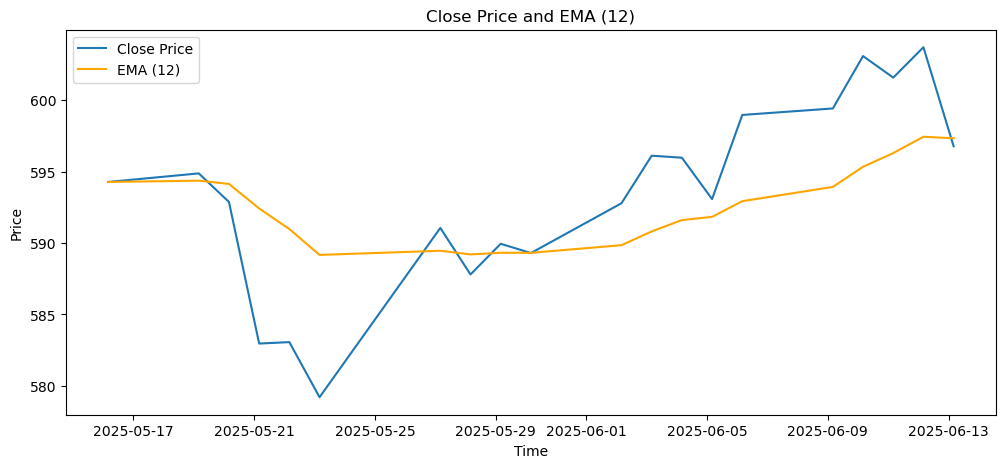

In [205]:
ema_series = calculate_ema(df, period=12)
plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['close'], label='Close Price')
sns.lineplot(x=df.index, y=ema_series, label='EMA (12)', color='orange')
plt.title('Close Price and EMA (12)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [206]:
def calculate_rsi(data: pd.DataFrame, period: int = 14) -> pd.Series:
    """Calculates the Relative Strength Index (RSI) for the given data."""
    if data.empty:
        logging.error("Cannot calculate RSI: input data is empty.")
        raise ValueError("Input data is empty.")

    if 'close' not in data.columns:
        logging.error("Column 'close' not found in data.")
        raise KeyError("Input data must contain a 'close' column.")

    try:
        delta = data['close'].diff().astype(float)
        gain = delta.where(delta > 0, 0.0).rolling(window=period).mean()
        loss = -delta.where(delta < 0, 0.0).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        logging.info(f"Calculated {period}-period RSI on {len(rsi)} data points.")
        return rsi
    except Exception as e:
        logging.error(f"Unexpected error during RSI calculation: {e}", exc_info=True)
        raise


In [207]:
rsi_series = calculate_rsi(df, period=14)
rsi_series

timestamp
2025-05-16 04:00:00+00:00          NaN
2025-05-19 04:00:00+00:00          NaN
2025-05-20 04:00:00+00:00          NaN
2025-05-21 04:00:00+00:00          NaN
2025-05-22 04:00:00+00:00          NaN
2025-05-23 04:00:00+00:00          NaN
2025-05-27 04:00:00+00:00          NaN
2025-05-28 04:00:00+00:00          NaN
2025-05-29 04:00:00+00:00          NaN
2025-05-30 04:00:00+00:00          NaN
2025-06-02 04:00:00+00:00          NaN
2025-06-03 04:00:00+00:00          NaN
2025-06-04 04:00:00+00:00          NaN
2025-06-05 04:00:00+00:00    48.644374
2025-06-06 04:00:00+00:00    54.680490
2025-06-09 04:00:00+00:00    54.549090
2025-06-10 04:00:00+00:00    59.887771
2025-06-11 04:00:00+00:00    71.527617
2025-06-12 04:00:00+00:00    72.803532
2025-06-13 04:00:00+00:00    68.168665
Name: close, dtype: float64

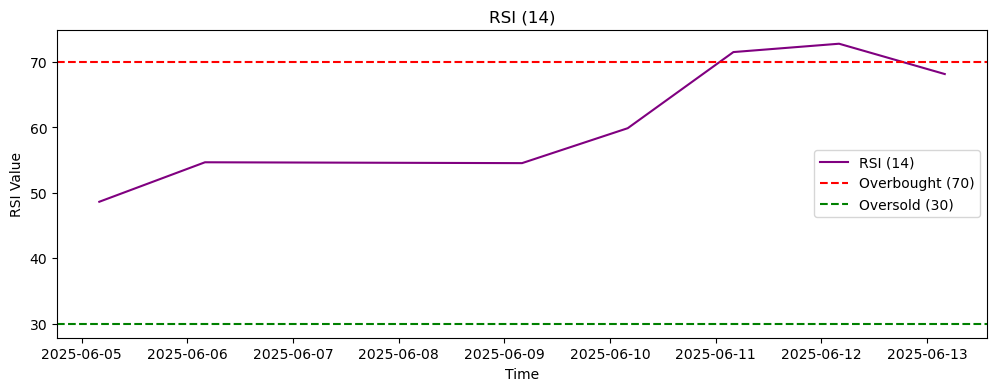

In [208]:
rsi_series = calculate_rsi(df, period=14)
plt.figure(figsize=(12, 4))
sns.lineplot(x=df.index, y=rsi_series, label='RSI (14)', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (14)')
plt.xlabel('Time')
plt.ylabel('RSI Value')
plt.legend()
plt.show()

In [209]:
def average_volume(data: pd.DataFrame, window: int = 20) -> pd.Series:
    """Calculates the average volume over a specified window."""
    if data.empty:
        logging.error("Cannot calculate average volume: input data is empty.")
        raise ValueError("Input data is empty.")

    if 'volume' not in data.columns:
        logging.error("Column 'volume' not found in input data.")
        raise KeyError("Input data must contain a 'volume' column.")

    try:
        avg_vol = data['volume'].rolling(window=window).mean()
        logging.info(f"Calculated {window}-period average volume on {len(avg_vol)} data points.")
        return avg_vol
    except Exception as e:
        logging.error(f"Unexpected error during average volume calculation: {e}", exc_info=True)
        raise


In [210]:
average_volume_series = average_volume(df)
average_volume_series

timestamp
2025-05-16 04:00:00+00:00           NaN
2025-05-19 04:00:00+00:00           NaN
2025-05-20 04:00:00+00:00           NaN
2025-05-21 04:00:00+00:00           NaN
2025-05-22 04:00:00+00:00           NaN
2025-05-23 04:00:00+00:00           NaN
2025-05-27 04:00:00+00:00           NaN
2025-05-28 04:00:00+00:00           NaN
2025-05-29 04:00:00+00:00           NaN
2025-05-30 04:00:00+00:00           NaN
2025-06-02 04:00:00+00:00           NaN
2025-06-03 04:00:00+00:00           NaN
2025-06-04 04:00:00+00:00           NaN
2025-06-05 04:00:00+00:00           NaN
2025-06-06 04:00:00+00:00           NaN
2025-06-09 04:00:00+00:00           NaN
2025-06-10 04:00:00+00:00           NaN
2025-06-11 04:00:00+00:00           NaN
2025-06-12 04:00:00+00:00           NaN
2025-06-13 04:00:00+00:00    1222048.05
Name: volume, dtype: float64

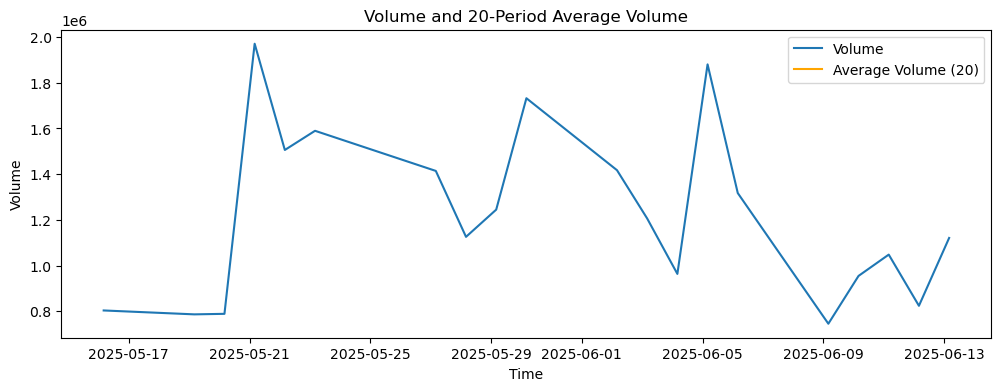

In [211]:
average_volume_series = average_volume(df)
plt.figure(figsize=(12, 4))
sns.lineplot(x=df.index, y=df['volume'], label='Volume')
sns.lineplot(x=df.index, y=average_volume_series, label='Average Volume (20)', color='orange')
plt.title('Volume and 20-Period Average Volume')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [212]:
def calculate_slope(series: pd.Series, window: int = 5) -> pd.Series:
    """Calculates the slope of the given series over a specified window."""
    if series.empty:
        logging.error("Cannot calculate slope: input series is empty.")
        raise ValueError("Input series is empty.")

    try:
        slope = series.diff().rolling(window=window).mean()
        logging.info(f"Calculated {window}-period slope on {len(slope)} data points.")
        return slope
    except Exception as e:
        logging.error(f"Unexpected error calculating slope: {e}", exc_info=True)
        raise

In [213]:
cal_slope_series = calculate_slope(df['close'])
cal_slope_series

timestamp
2025-05-16 04:00:00+00:00      NaN
2025-05-19 04:00:00+00:00      NaN
2025-05-20 04:00:00+00:00      NaN
2025-05-21 04:00:00+00:00      NaN
2025-05-22 04:00:00+00:00      NaN
2025-05-23 04:00:00+00:00   -3.016
2025-05-27 04:00:00+00:00   -0.764
2025-05-28 04:00:00+00:00   -1.016
2025-05-29 04:00:00+00:00    1.398
2025-05-30 04:00:00+00:00    1.248
2025-06-02 04:00:00+00:00    2.718
2025-06-03 04:00:00+00:00    1.012
2025-06-04 04:00:00+00:00    1.636
2025-06-05 04:00:00+00:00    0.626
2025-06-06 04:00:00+00:00    1.935
2025-06-09 04:00:00+00:00    1.328
2025-06-10 04:00:00+00:00    1.396
2025-06-11 04:00:00+00:00    1.122
2025-06-12 04:00:00+00:00    2.128
2025-06-13 04:00:00+00:00   -0.439
Name: close, dtype: float64

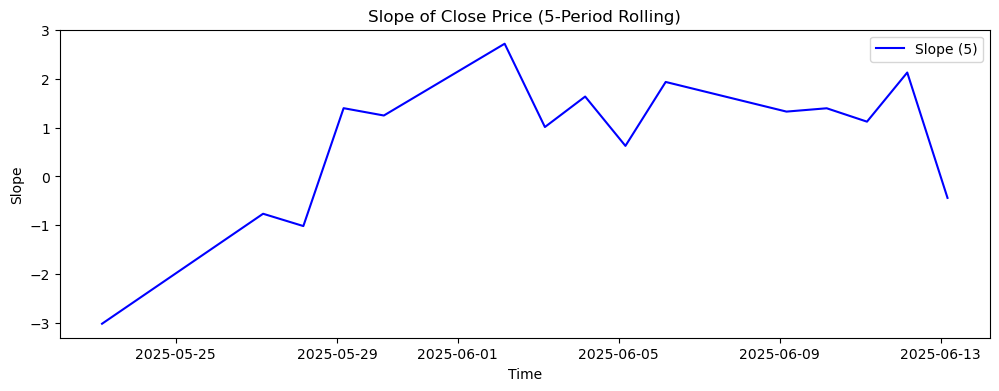

In [214]:
cal_slope_series = calculate_slope(df['close'])
plt.figure(figsize=(12, 4))
sns.lineplot(x=df.index, y=cal_slope_series, label='Slope (5)', color='blue')
plt.title('Slope of Close Price (5-Period Rolling)')
plt.xlabel('Time')
plt.ylabel('Slope')
plt.legend()
plt.show()

In [215]:
def check_missing_values(df: pd.DataFrame) -> pd.Series:
    """Checks for missing values in the DataFrame and returns a Series with counts."""
    if df.empty:
        logging.error("Cannot check missing values: input DataFrame is empty.")
        raise ValueError("Input DataFrame is empty.")

    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]

    if not missing_values.empty:
        logging.warning(f"Missing values found:\n{missing_values}")
    else:
        logging.info("No missing values found in the DataFrame.")

    return missing_values

In [216]:
check_missing_values(df)

Series([], dtype: int64)

In [217]:
def remove_dividends_splits(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """Removes specified columns from the DataFrame."""
    if df.empty:
        logging.error("Cannot remove columns: input DataFrame is empty.")
        raise ValueError("Input DataFrame is empty.")

    try:
        df = df.drop(columns=columns)
        logging.info(f"Removed columns: {columns}")
    except KeyError as e:
        logging.warning(f"One or more specified columns not found in DataFrame: {e}")
    except Exception as e:
        logging.error(f"Unexpected error while removing columns: {e}", exc_info=True)

    logging.debug(f"Remaining columns: {df.columns.tolist()}")
    return df


In [218]:
df_removed = remove_dividends_splits(df, ['dividends', 'splits'])
df_removed.columns

Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count',
       'vwap'],
      dtype='object')

In [219]:
def save_all_open_positions(api: tradeapi.REST, filename: str = "position.json") -> None:
    """Saves all open positions to a JSON file."""
    try:
        positions: list = api.list_positions()
        positions_data = [p._raw for p in positions]

        with open(filename, "w") as f:
            json.dump(positions_data, f, indent=4)

        logging.info(f"Saved {len(positions_data)} open positions to {filename}.")
    except Exception as e:
        logging.error(f"Failed to save open positions to {filename}: {e}", exc_info=True)


In [220]:
def fetch_open_positions(api: tradeapi.REST) -> list:
    """Fetches and returns all open positions."""
    try:
        positions: list = api.list_positions()
        if not positions:
            logging.info("No open positions found.")
        else:
            logging.info(f"Fetched {len(positions)} open positions.")
        return positions
    except Exception as e:
        logging.error(f"Error fetching open positions: {e}", exc_info=True)
        return []

In [221]:
if api is not None:
    save_all_open_positions(api)
    open_positions = fetch_open_positions(api)
    for position in open_positions:
        symbol = position.symbol
        qty = position.qty
        entry_price = position.avg_entry_price
        current_price = position.current_price
        unrealized_pl = position.unrealized_pl
        print(
            f"Symbol: {symbol}, Qty: {qty}, Entry: {entry_price}, "
            f"Current: {current_price}, Unrealized PnL: {unrealized_pl}"
        )
else:
    print("API connection is not available.")

Symbol: SPY, Qty: 56.459157247, Entry: 600.584844, Current: 597, Unrealized PnL: -202.397292


In [222]:
def convert_row_to_numeric(row: pd.Series, df: pd.DataFrame) -> pd.Series:
    """
    Converts the values in the given row to a consistent numeric format
    for all numeric columns in df. Returns the modified row.
    """
    numerical_columns = df.select_dtypes(include='number').columns.tolist()

    for col in numerical_columns:
        try:
            val = row[col]
            if pd.isna(val) or str(val).strip().lower() in ['', 'none', 'nan']:
                raise ValueError(f"Missing or empty value for column '{col}'")
            row[col] = float(val) if not isinstance(val, float) else val
        except Exception as e:
            logging.warning(f"Data conversion error for '{col}': {e}")

    return row

In [223]:
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds EMA(9), slope of EMA(9), RSI(14), and 20-period average volume to the DataFrame.
    Returns the DataFrame with new columns: 'ema9', 'slope9', 'rsi', 'avg_volume'.
    """
    if df.empty:
        logging.error("Cannot add indicators: input DataFrame is empty.")
        raise ValueError("Input DataFrame is empty.")

    df = df.copy()

    try:
        df['ema9'] = calculate_ema(df, period=9)
        df['slope9'] = calculate_slope(df['ema9'])
        df['rsi'] = calculate_rsi(df)
        df['avg_volume'] = average_volume(df)
        logging.info("Successfully added indicators: ema9, slope9, rsi, avg_volume.")
    except Exception as e:
        logging.error(f"Error while adding indicators: {e}", exc_info=True)
        raise

    return df

In [224]:
def is_cooldown(last_exit_str: str, now: datetime, cooldown: int = COOLDOWN) -> bool:
    """
    Checks if the cooldown period is active based on last_exit_str and current time.
    Returns True if cooldown is active, False otherwise.
    """
    if last_exit_str:
        try:
            last_exit = datetime.fromisoformat(last_exit_str)
            logging.debug(f"Parsed last_exit: {last_exit}")

            time_from_last_exit = int((now - last_exit).total_seconds())
            time_left = cooldown - time_from_last_exit

            logging.debug(f"time_from_last_exit: {time_from_last_exit}")
            logging.debug(f"time_left: {time_left}")

            if time_left > 0:
                logging.info(
                    f"Cooldown active for {time_left} more seconds. "
                    f"Last trade was at {last_exit.strftime('%H:%M:%S')}"
                )
                return True
        except ValueError:
            logging.warning(f"Invalid ISO format for 'last_exit': '{last_exit_str}'. No cooldown applied.")
    else:
        logging.info("'last_exit' is empty. No cooldown applied.")

    return False

In [225]:
def main():
    """Main trading logic with cooldown check and daily limits."""
    
    # Load current position
    position = load_position()
    logging.info(f"Loaded position: {position}")

    # Check if position is valid and non-empty
    if not position or not isinstance(position, list) or not position[0]:
        logging.warning("No position data found. Exiting.")
        return

    # Cooldown check
    now = datetime.now()
    logging.debug(f"Current datetime: {now}")

    last_exit_str = position[0].get('last_exit', '')
    logging.debug(f"Last exit string: '{last_exit_str}'")

    if is_cooldown(last_exit_str, now, COOLDOWN):
        return
    else:
        logging.info("Cooldown not active. Proceeding with trade logic.")

    # Daily trade limits check
    trade_count, daily_pnl = check_daily_limits()
    if trade_count >= MAX_TRADES_PER_DAY or daily_pnl <= -DAILY_LOSS_LIMIT:
        logging.warning(
            f"Daily limit reached. Trade count: {trade_count}, Daily PnL: {daily_pnl}. "
            "No trades will be made today."
        )
        return

    # Get latest quote safely
    try:
        client = get_historical_data_client()
        quote = client.get_stock_latest_quote(
            StockLatestQuoteRequest(symbol_or_symbols=SYMBOL)
        )
        logging.info(f"Fetched latest quote for {SYMBOL}: {quote}")
    except ValueError as e:
        logging.error(f"Error initializing data client: {e}", exc_info=True)
        return

    
    # HERE
    df_1m = get_data(SYMBOL, '1m', 30)
    df_5m = get_data(SYMBOL, '5m', 30)

    if df_1m.empty or df_5m.empty:
        print("Data unavailable.")
        return

    # Check for missing values
    if not df_1m.isnull().sum().sum() == 0 or not df_5m.isnull().sum().sum() == 0:
        print("Missing data detected. Skipping trade.")
        return

    df_1m = add_indicators(df_1m)
    df_5m = add_indicators(df_5m)

    last = df_1m.iloc[-1].copy()
    #print("Raw last row values:")
    for k, v in last.items():
        print(f"  {k}: {v}")

    last = df_1m.iloc[-1].copy()
    last = convert_row_to_numeric(last, df_1m)

    # #last

    slope = float(df_5m['slope9'].iloc[-1])  # Updated to use 'slope9'
    print(f"Slope: {slope}")
    side = position[0].get('side')
    print(f"Side: {side}")
    qty = position[0].get('qty', 0)
    print(f"Qty: {qty}")
    entry_price = position[0].get('avg_entry_price', 0)
    print(f"Entry price: {entry_price}")
    buying_power = float(api.get_account().cash)
    current_price = quote[SYMBOL].ask_price
    print(f"Current price: {current_price}")
    print(f"Buying power: {buying_power}")
    trade_qty = int((buying_power * POSITION_SIZE_PCT) / last['close'])
    print(f"Trade qty: {trade_qty}")

    # No position
    if not side:
        print("No position found")
        # if last['Close'] > last['Open'] and last['Close'] > last['ema9'] and last['rsi'] < 65 and last['Volume'] > last['avg_volume'] and slope > 0:
        #     price = last['Close'] * 1.001
        #     place_order('buy', trade_qty, price)
        #     save_position({'side': 'long', 'entry_price': price, 'qty': trade_qty, 'high': price, 'entry_time': now.isoformat()})

        # elif last['Close'] < last['Open'] and last['Close'] < last['ema9'] and last['rsi'] > 55 and last['Volume'] > last['avg_volume'] and slope < 0:
        #     price = last['Close'] * 0.999
        #     place_order('sell', trade_qty, price)
        #     save_position({'side': 'short', 'entry_price': price, 'qty': trade_qty, 'low': price, 'entry_time': now.isoformat()})

    # Long Position
    elif side == 'long':
        print("Long Position")
        # print("Long Position")
        # position['high'] = max(position['high'], last['Close'])
        # trail_stop = position['high'] * (1 - TRAILING_STOP_PCT)
        # print(f"[LONG] Comparing last['Close'] = {last['Close']} (type: {type(last['Close'])}) to trail_stop = {trail_stop}")
        # last_close = float(last['Close'])
        # if last_close <= trail_stop or last_close < last['ema9']:
        #     close_position()
        #     exit_price = last['Close']
        #     pnl = (exit_price - entry_price) * qty
        #     log_trade(position['entry_time'], now.isoformat(), side, entry_price, exit_price, pnl)
        #     #reset_position()
        #     save_position({'last_exit': now.isoformat()})

    # # Short Position
    elif side == 'short':
        print("Short Position")
        # position['low'] = min(position['low'], last['Close'])
        # trail_stop = position['low'] * (1 + TRAILING_STOP_PCT)
        # print(f"[SHORT] Comparing last['Close'] = {last['Close']} (type: {type(last['Close'])}) to trail_stop = {trail_stop}")
        # last_close = float(last['Close'])
        # if last_close >= trail_stop or last_close > last['ema9']:
        #     close_position()
        #     exit_price = last['Close']
        #     pnl = (entry_price - exit_price) * qty
        #     log_trade(position['entry_time'], now.isoformat(), side, entry_price, exit_price, pnl)
        #     #reset_position()
        #     save_position({'last_exit': now.isoformat()})


In [226]:
if __name__ == "__main__":
    logging.info("Starting the trading bot...")
    create_trade_log_file()
    main()

Data unavailable.
